# Customer Analytics for a Telecom Provider

## Importing Libraries

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading & Reading Dataset

In [5]:
df = pd.read_csv("dataset/telecom_customer_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,CUST00001,Male,0,Yes,No,54,No,No phone service,Fiber optic,No internet service,Yes,No internet service,Yes,No internet service,No internet service,Two year,Yes,Mailed check,96.48,No
1,CUST00002,Female,0,No,No,35,Yes,No,No,Yes,No,Yes,Yes,No,No internet service,One year,No,Credit card (automatic),87.58,No
2,CUST00003,Male,0,Yes,No,36,Yes,No phone service,No,No internet service,No internet service,No internet service,Yes,Yes,Yes,Month-to-month,No,Bank transfer (automatic),79.78,No
3,CUST00004,Male,0,No,Yes,13,No,No phone service,Fiber optic,No,Yes,No,No,No internet service,No internet service,One year,Yes,Bank transfer (automatic),112.28,Yes
4,CUST00005,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No internet service,No internet service,Month-to-month,Yes,Mailed check,45.77,Yes


#### Info about data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5000 non-null   object 
 1   gender            5000 non-null   object 
 2   SeniorCitizen     5000 non-null   int64  
 3   Partner           5000 non-null   object 
 4   Dependents        5000 non-null   object 
 5   tenure            5000 non-null   int64  
 6   PhoneService      5000 non-null   object 
 7   MultipleLines     5000 non-null   object 
 8   InternetService   5000 non-null   object 
 9   OnlineSecurity    5000 non-null   object 
 10  OnlineBackup      5000 non-null   object 
 11  DeviceProtection  5000 non-null   object 
 12  TechSupport       5000 non-null   object 
 13  StreamingTV       5000 non-null   object 
 14  StreamingMovies   5000 non-null   object 
 15  Contract          5000 non-null   object 
 16  PaperlessBilling  5000 non-null   object 


#### Descriptive Statistics of data

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5000.0,0.498200,0.500047,0.0,0.0000,0.000,1.000,1.0
tenure,5000.0,35.828400,20.994340,0.0,17.7500,36.000,54.000,72.0
MonthlyCharges,5000.0,70.229976,27.907778,18.0,49.4375,70.185,90.895,120.0


In [8]:
df.describe(include=['object']).T

,count,unique,top,freq
customerID,5000,5000,CUST05000,1
gender,5000,2,Male,2504
Partner,5000,2,Yes,2508
Dependents,5000,2,No,2501
PhoneService,5000,2,No,2542
MultipleLines,5000,3,No phone service,1712
InternetService,5000,3,DSL,1782
OnlineSecurity,5000,3,No internet service,1740
OnlineBackup,5000,3,No,1690
DeviceProtection,5000,3,No,1755


In [9]:
df1 = df.copy()

## Data Cleaning

#### Dropping unnecessary column

In [10]:
# Dropping Customer ID
df1.drop('customerID', axis=1, inplace=True, errors='ignore')

#### Finding Duplicates

In [11]:
df1.duplicated().any()

np.False_

**So, here are no duplicate entries.**

#### Finding Missing Values

In [12]:
# Remove leading/trailing whitespaces from all object columns.
# This helps detect hidden missing values like '   ' or 'NaN ' (with spaces), which are strings and not recognized as actual NaN by pandas.
for column in df1.select_dtypes(include=['object']).columns:
    df1[column] = df1[column].str.strip()

In [13]:
# Identifying 0 values with tenure
df1[df1['tenure'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
195,Female,0,Yes,No,0,No,No phone service,No,No,No,No,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),107.91,Yes
319,Female,1,No,No,0,Yes,No phone service,Fiber optic,No internet service,No internet service,No,No,No,No internet service,Month-to-month,No,Mailed check,120.00,Yes
623,Female,0,No,Yes,0,Yes,No,Fiber optic,No,No internet service,No internet service,No internet service,No internet service,Yes,One year,Yes,Bank transfer (automatic),80.98,Yes
739,Female,0,Yes,No,0,Yes,Yes,DSL,Yes,No internet service,No,No internet service,No internet service,Yes,Two year,Yes,Mailed check,40.03,No
800,Male,1,No,No,0,No,No,Fiber optic,No internet service,Yes,No,Yes,No,Yes,Two year,No,Mailed check,76.33,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4631,Male,1,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,Yes,No internet service,Yes,Month-to-month,No,Electronic check,73.71,Yes
4662,Male,1,Yes,Yes,0,Yes,Yes,No,No,No internet service,No,No,Yes,No internet service,One year,Yes,Bank transfer (automatic),47.75,Yes
4942,Female,1,No,Yes,0,Yes,No phone service,DSL,No,Yes,No,Yes,No,No internet service,Month-to-month,Yes,Credit card (automatic),47.32,No
4951,Female,1,No,No,0,No,No,Fiber optic,Yes,No,No internet service,No internet service,Yes,No,One year,No,Bank transfer (automatic),87.02,Yes


**69 records with 0 values in tenure**

In [14]:
# dropping records with 0 values in tenure
df1.drop(labels=df1[df1['tenure'] == 0].index, axis=0, inplace=True)

In [15]:
# checking missing values 
df1.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

**So, Here no missing values present.**

#### Dividing Categorical and Numerical Features (Excluding Target)

In [16]:
df1['SeniorCitizen'] = df1['SeniorCitizen'].apply(lambda x:str(int(x)))

In [17]:
target_col = ['Churn']
numerical_cols = []
categorical_cols = []

separate_cat_num_cols = [categorical_cols.append(col) if df1[col].dtype == 'object' else numerical_cols.append(col) for col in df1.columns if col not in target_col]

In [18]:
numerical_cols

['tenure', 'MonthlyCharges']

In [19]:
categorical_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Finding Outliers

#### Finding outliers using boxplot in numerical columns

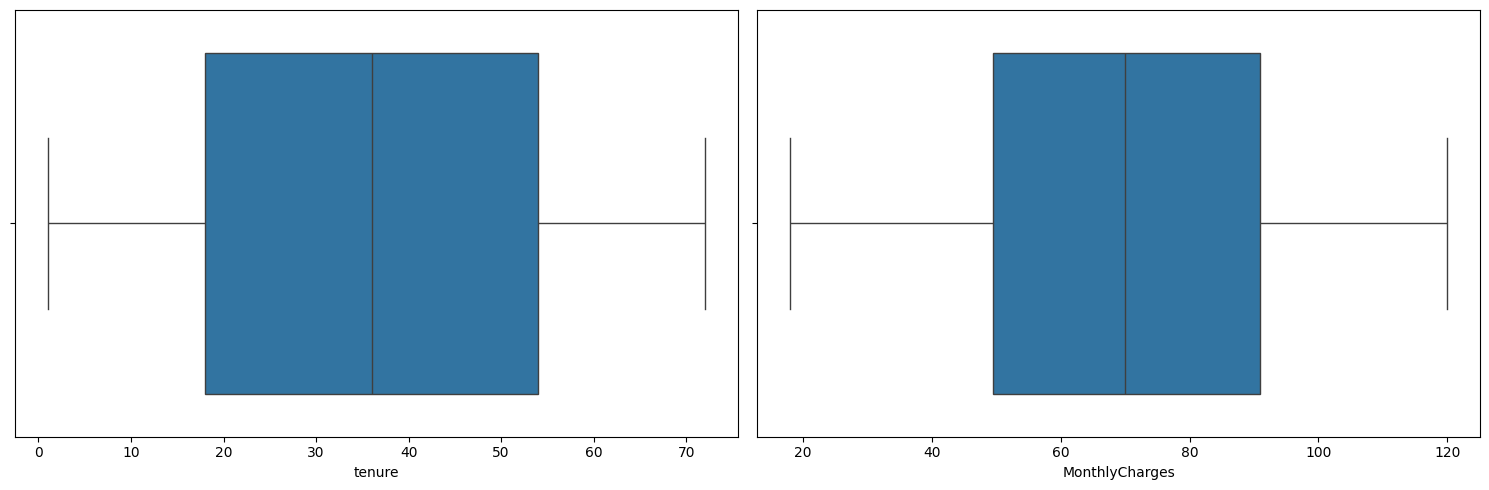

In [20]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 5))

for i, column in enumerate(numerical_cols):
    sns.boxplot(data=df1, x=column, ax=axes[i])
    
plt.tight_layout()
plt.show()

So, Here no outliers in numerical columns.

### Fix Data Inconsistencies

#### Identifying Inconsistent 'MultipleLines' Values Based on 'PhoneService'

In [21]:
df1['Inconsistent_multiplelines'] = ((df1['PhoneService'] == "No") & (df1['MultipleLines'] == "Yes"))
df1['Inconsistent_multiplelines'].value_counts()

Inconsistent_multiplelines
False    4097
True      834
Name: count, dtype: int64

If a customer does not have **'PhoneService'**, then they cannot have **'MultipleLines'**.

So according to value counts of 'Inconsistent_multiplelines' 845 entries contains wrong data.

#### Correcting Inconsistent 'MultipleLines' Values by replacing 'Yes' with 'No phone service' where PhoneService is 'No'

In [22]:
# Replace 'Yes' with 'No phone service' where PhoneService is 'No'
df1.loc[(df1['PhoneService'] == 'No') & (df1['MultipleLines'] == 'Yes'), 'MultipleLines'] = 'No phone service'

In [23]:
# drop 'Inconsistent_multiplelines' column 
df1.drop('Inconsistent_multiplelines', axis=1, inplace=True)

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4931 non-null   object 
 1   SeniorCitizen     4931 non-null   object 
 2   Partner           4931 non-null   object 
 3   Dependents        4931 non-null   object 
 4   tenure            4931 non-null   int64  
 5   PhoneService      4931 non-null   object 
 6   MultipleLines     4931 non-null   object 
 7   InternetService   4931 non-null   object 
 8   OnlineSecurity    4931 non-null   object 
 9   OnlineBackup      4931 non-null   object 
 10  DeviceProtection  4931 non-null   object 
 11  TechSupport       4931 non-null   object 
 12  StreamingTV       4931 non-null   object 
 13  StreamingMovies   4931 non-null   object 
 14  Contract          4931 non-null   object 
 15  PaperlessBilling  4931 non-null   object 
 16  PaymentMethod     4931 non-null   object 
 17  

#### Identifying Invalid 'Yes' Values for Internet-Dependent Services 

In [25]:
# Columns that depend on InternetService
internet_dependent_cols = ['OnlineSecurity', 'OnlineBackup', 'StreamingTV', 'StreamingMovies', 'DeviceProtection', 'TechSupport']

In [26]:
# Count 'Yes' values in those columns where InternetService is 'No' (invalid data)
total_records_to_update = 0
print("Records with invalid 'Yes' values when InternetService is 'No':\n")

for col in internet_dependent_cols:
    invalid_count = df1.loc[(df1['InternetService'] == 'No') & (df1[col] == 'Yes')].shape[0]
    print(f"- {invalid_count} records in column '{col}' need to be updated.")
    total_records_to_update += invalid_count

# Count records where all 4 columns have 'Yes' and InternetService is 'No' (common wrong data)
all_cols_invalid = df1.loc[
    (df1['InternetService'] == 'No') &
    (df1['OnlineSecurity'] == 'Yes') &
    (df1['OnlineBackup'] == 'Yes') &
    (df1['StreamingTV'] == 'Yes') &
    (df1['StreamingMovies'] == 'Yes') & 
    (df1['DeviceProtection'] == 'Yes') &
    (df1['TechSupport'] == 'Yes')
].shape[0]

print(f"\n {all_cols_invalid} records have 'Yes' in **all** internet-dependent columns despite InternetService being 'No'.")
print(f"\n Total individual updates to be made: {total_records_to_update}\n")

Records with invalid 'Yes' values when InternetService is 'No':

- 542 records in column 'OnlineSecurity' need to be updated.
- 529 records in column 'OnlineBackup' need to be updated.
- 533 records in column 'StreamingTV' need to be updated.
- 522 records in column 'StreamingMovies' need to be updated.
- 542 records in column 'DeviceProtection' need to be updated.
- 508 records in column 'TechSupport' need to be updated.

 2 records have 'Yes' in **all** internet-dependent columns despite InternetService being 'No'.

 Total individual updates to be made: 3176



####  Replacing Invalid 'Yes' Values with 'No internet service'

In [27]:
# Perform the updates
updated_record_count = 0
for col in internet_dependent_cols:
    mask = (df1['InternetService'] == 'No') & (df1[col] == 'Yes')
    updated_record_count += mask.sum()
    df1.loc[mask, col] = 'No internet service'

print(f"Total records successfully updated: {updated_record_count}")

Total records successfully updated: 3176


#### Replacing 'No Internet Service' & 'No Phone Service' with 'No'

In [28]:
# Replacing 'No Internet Service' & 'No Phone Service' with 'No'
for col in df1.columns:
    df1[col] = df1[col].apply(lambda x : 'No' if type(x)==str and x.lower() in ('no phone service', 'no internet service') else x)

In [29]:
df1

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Male,0,Yes,No,54,No,No,Fiber optic,No,Yes,No,Yes,No,No,Two year,Yes,Mailed check,96.48,No
1,Female,0,No,No,35,Yes,No,No,No,No,No,No,No,No,One year,No,Credit card (automatic),87.58,No
2,Male,0,Yes,No,36,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),79.78,No
3,Male,0,No,Yes,13,No,No,Fiber optic,No,Yes,No,No,No,No,One year,Yes,Bank transfer (automatic),112.28,Yes
4,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,45.77,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,1,Yes,Yes,35,No,No,No,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),107.53,Yes
4996,Female,0,No,Yes,70,No,No,DSL,No,No,No,No,Yes,No,One year,Yes,Mailed check,78.94,Yes
4997,Male,1,Yes,Yes,16,No,No,No,No,No,No,No,No,No,Two year,No,Bank transfer (automatic),91.49,No
4998,Female,1,No,No,47,No,No,No,No,No,No,No,No,No,One year,Yes,Credit card (automatic),47.74,No


#### Creating New Feature = 'TotalInternetServicesUsed' which shows all services used by customer

In [30]:
df1['TotalInternetServicesUsed'] = df1[['OnlineSecurity','OnlineBackup','TechSupport','DeviceProtection','StreamingTV','StreamingMovies']].apply(lambda x : sum(map(lambda y: 1 if y == 'Yes' else 0,x)),axis=1)

In [31]:
df1['TotalInternetServicesUsed'].value_counts()

TotalInternetServicesUsed
0    1913
2    1085
1     886
3     724
4     274
5      45
6       4
Name: count, dtype: int64

In [32]:
df1['tenure'].value_counts()

tenure
14    103
20     87
37     84
51     83
17     82
     ... 
32     56
34     55
11     53
69     47
10     39
Name: count, Length: 72, dtype: int64

#### Creating New Feature - Tenure in 12 months group

In [33]:
# Create 6-month bins for tenure
bin_edges = np.arange(1, 73, 12)
bin_edges = np.append(bin_edges, 73)
df1['Tenure_(12-month_groups)'] = pd.cut(df1['tenure'], bins=bin_edges, right=False)

In [34]:
df1.shape

(4931, 21)

In [35]:
df1['tenure'].describe()

count    4931.000000
mean       36.329751
std        20.705399
min         1.000000
25%        18.000000
50%        36.000000
75%        54.000000
max        72.000000
Name: tenure, dtype: float64

In [36]:
# drop original column tenure
df1 = df1.drop('tenure', axis=1, errors='ignore')

In [37]:
df1['Tenure_(12-month_groups)'].isnull().sum()

np.int64(0)

In [38]:
df1['Tenure_(12-month_groups)'].value_counts()

Tenure_(12-month_groups)
[13, 25)    885
[61, 73)    823
[37, 49)    822
[49, 61)    815
[25, 37)    799
[1, 13)     787
Name: count, dtype: int64

In [39]:
# removing original 'tenure' from numerical cols list
if 'tenure' in numerical_cols:
    numerical_cols.remove('tenure')

In [ ]:
# adding new 'Tenure_(12-month_groups)' in numerical cols list
if 'Tenure_(12-month_groups)' not in numerical_cols:
    numerical_cols.append('Tenure_(12-month_groups)')

In [41]:
numerical_cols

['MonthlyCharges', 'Tenure_(12-month_groups)']

## EDA - Exploratory Data Analysis

### Label Encoding on Target Variable for EDA

In [42]:
# label encoding on target variable
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])
# print(le.classes_)
# print(le.transform(df1['Churn']))

0 = No churn, 1 = Yes churn

In [43]:
df1[['Churn']].head()

,Churn
0,0
1,0
2,0
3,1
4,1


### Churn Target Variable Visualization

Churn
0    3622
1    1309
Name: count, dtype: int64

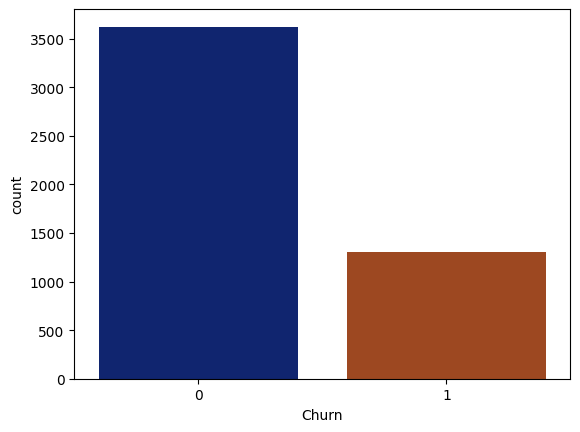

In [44]:
sns.countplot(x='Churn', data=df1, palette='dark')
df1['Churn'].value_counts()

**So, Here data is imbalanced with a ratio of approximately 3:1**

### Categorical Features and Their Impact on the Target Variable (Churn)

In [45]:
categorical_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

#### Categorical Features Grouped: Customer Info, Services Signed, and Payment Details

In [46]:
l1 = ['SeniorCitizen','Partner','Dependents'] # Customer Information
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
l3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information

#### Group 1: Customer Information

This group covers simple info about the customer
- SeniorCitizen
- Partner
- Dependents

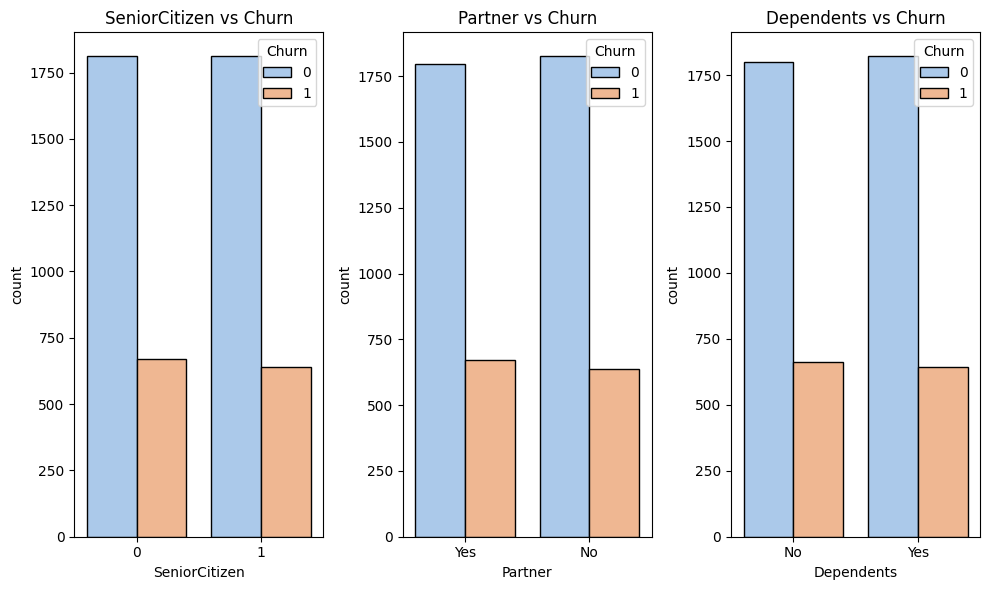

In [47]:
fig = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
for i in range(len(l1)):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=l1[i], data=df1, hue="Churn", palette='pastel', edgecolor='black')
    plt.title(f"{l1[i]} vs Churn")
plt.tight_layout()

In [48]:
(df1.groupby('SeniorCitizen')['Churn'].mean().rename('churn_rate'),
 df1.groupby('Partner')['Churn'].mean().rename('churn_rate'),
 df1.groupby('Dependents')['Churn'].mean().rename('churn_rate'))


(SeniorCitizen
 0    0.269758
 1    0.261118
 Name: churn_rate, dtype: float64,
 Partner
 No     0.258733
 Yes    0.272175
 Name: churn_rate, dtype: float64,
 Dependents
 No     0.269371
 Yes    0.261557
 Name: churn_rate, dtype: float64)

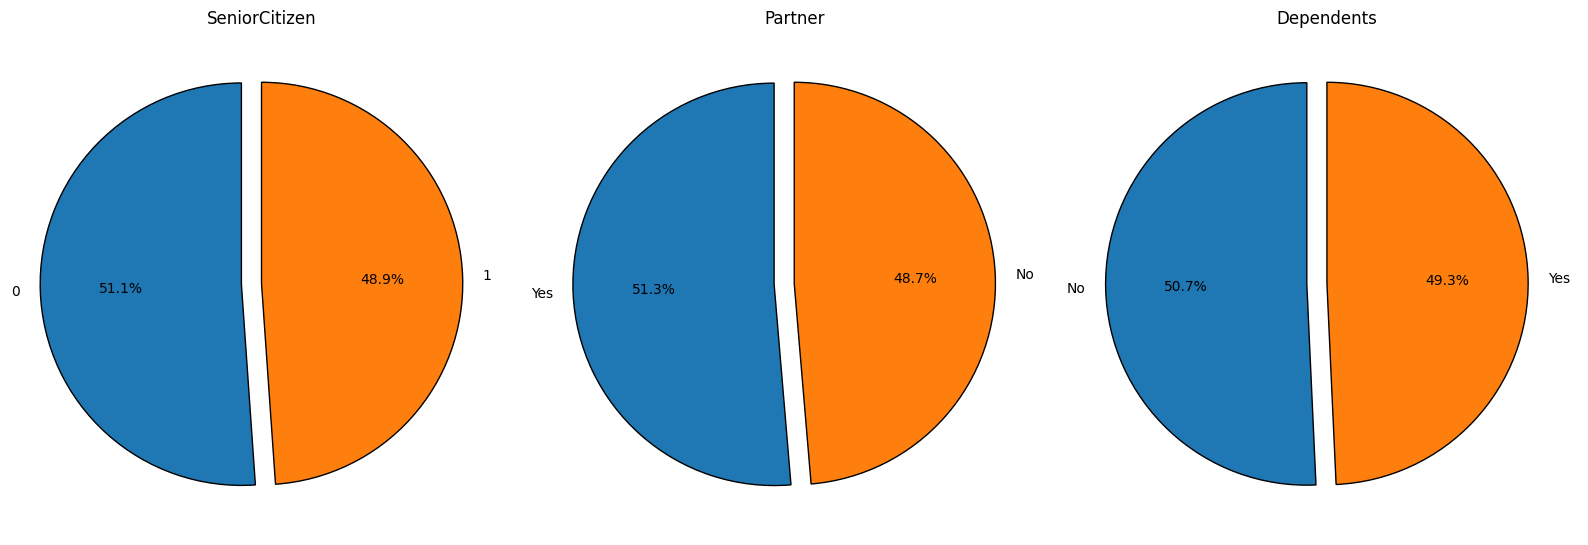

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i, col in enumerate(l1):
    val_counts = df1[df1['Churn'] == 1][col].value_counts(normalize=True) * 100
    labels = val_counts.index.tolist()
    
    axes[i].pie(val_counts, labels=labels, autopct='%1.1f%%',
                startangle=90, explode=[0.1] + [0] * (len(labels) - 1),
                wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


- Senior Citizen: Churn is about the same for seniors and non-seniors, No real difference.

- Partner: Customers with a partner leave slightly more than those without. The gap is tiny.

- Dependents: Households with dependents churn a little less than those without. Also a small gap.
So, churn across the customer-information groups is nearly balanced, indicating no strong influence of these attributes on customer retention.

#### Group 2: Customer-Enlisted Services

This group covers services subscribed by customer into two groups:

Gorup 1
- PhoneService
- MultipleLines
- InternetService
- StreamingTV
- StreamingMovies

Group 2 - Security & Support Services
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport

#### Group 2.1

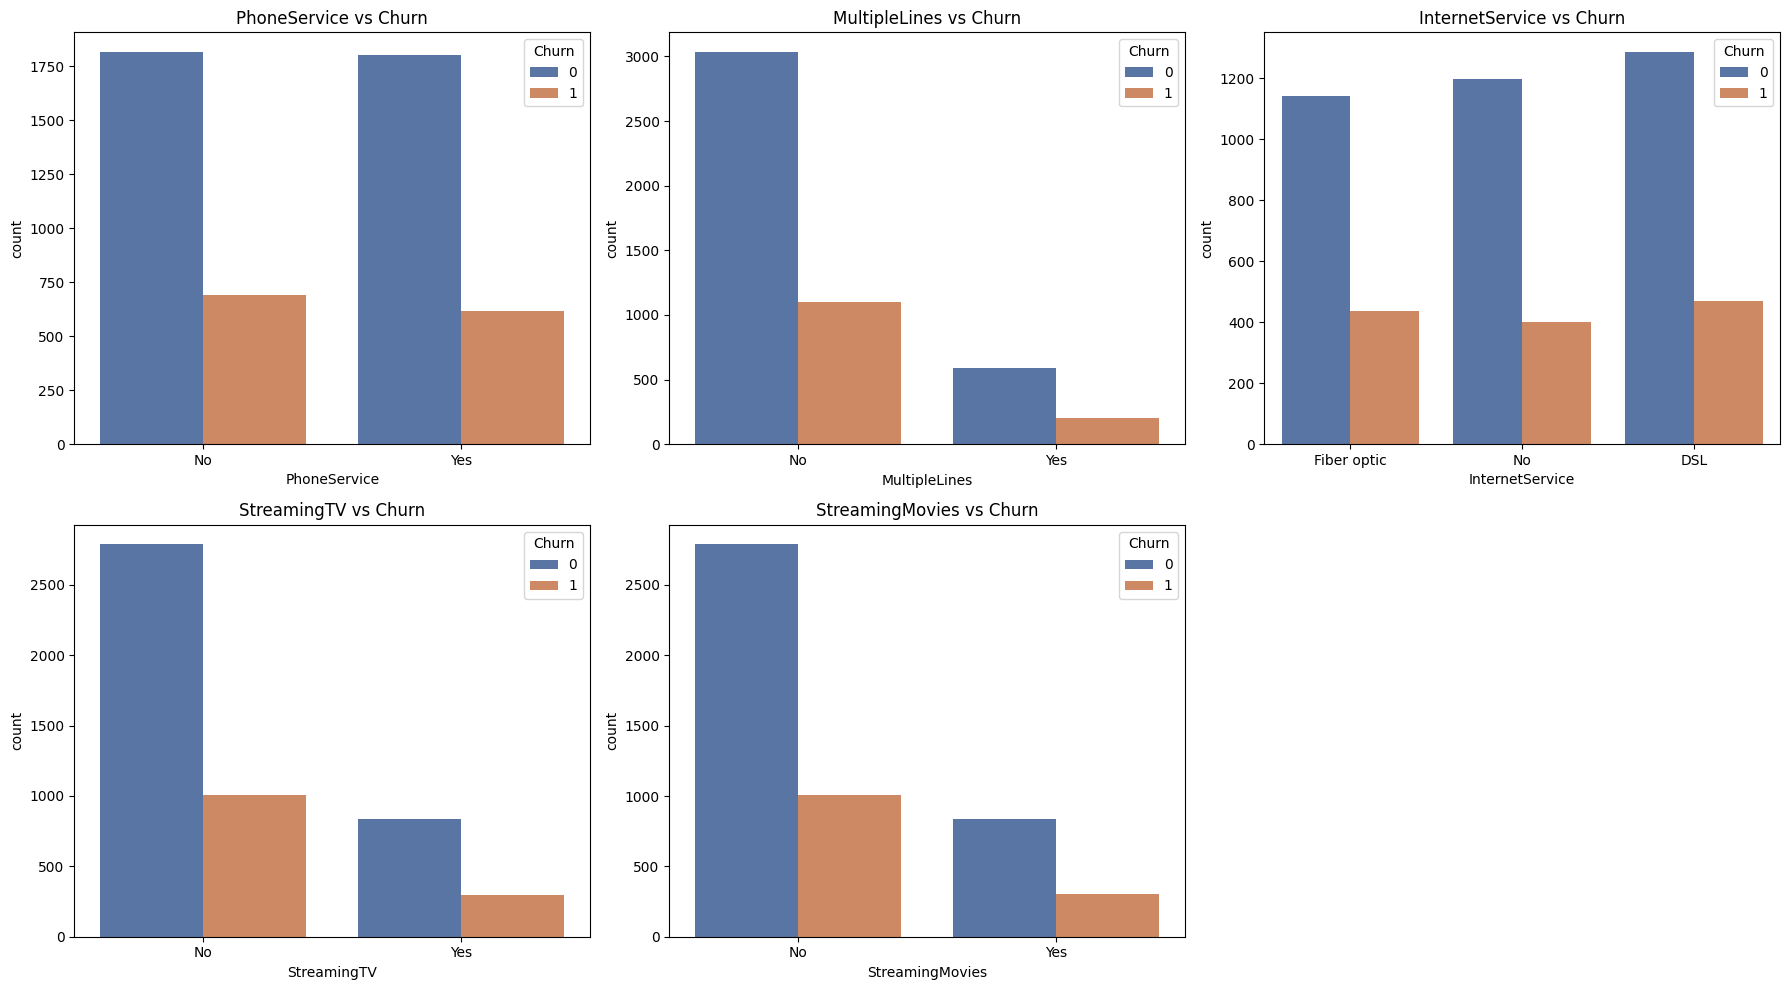

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i in range(5):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.countplot(x=l2[i], data=df1, hue="Churn", palette='deep', ax=ax)
    ax.set_title(f"{l2[i]} vs Churn")

# Hide the 6th (empty) subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


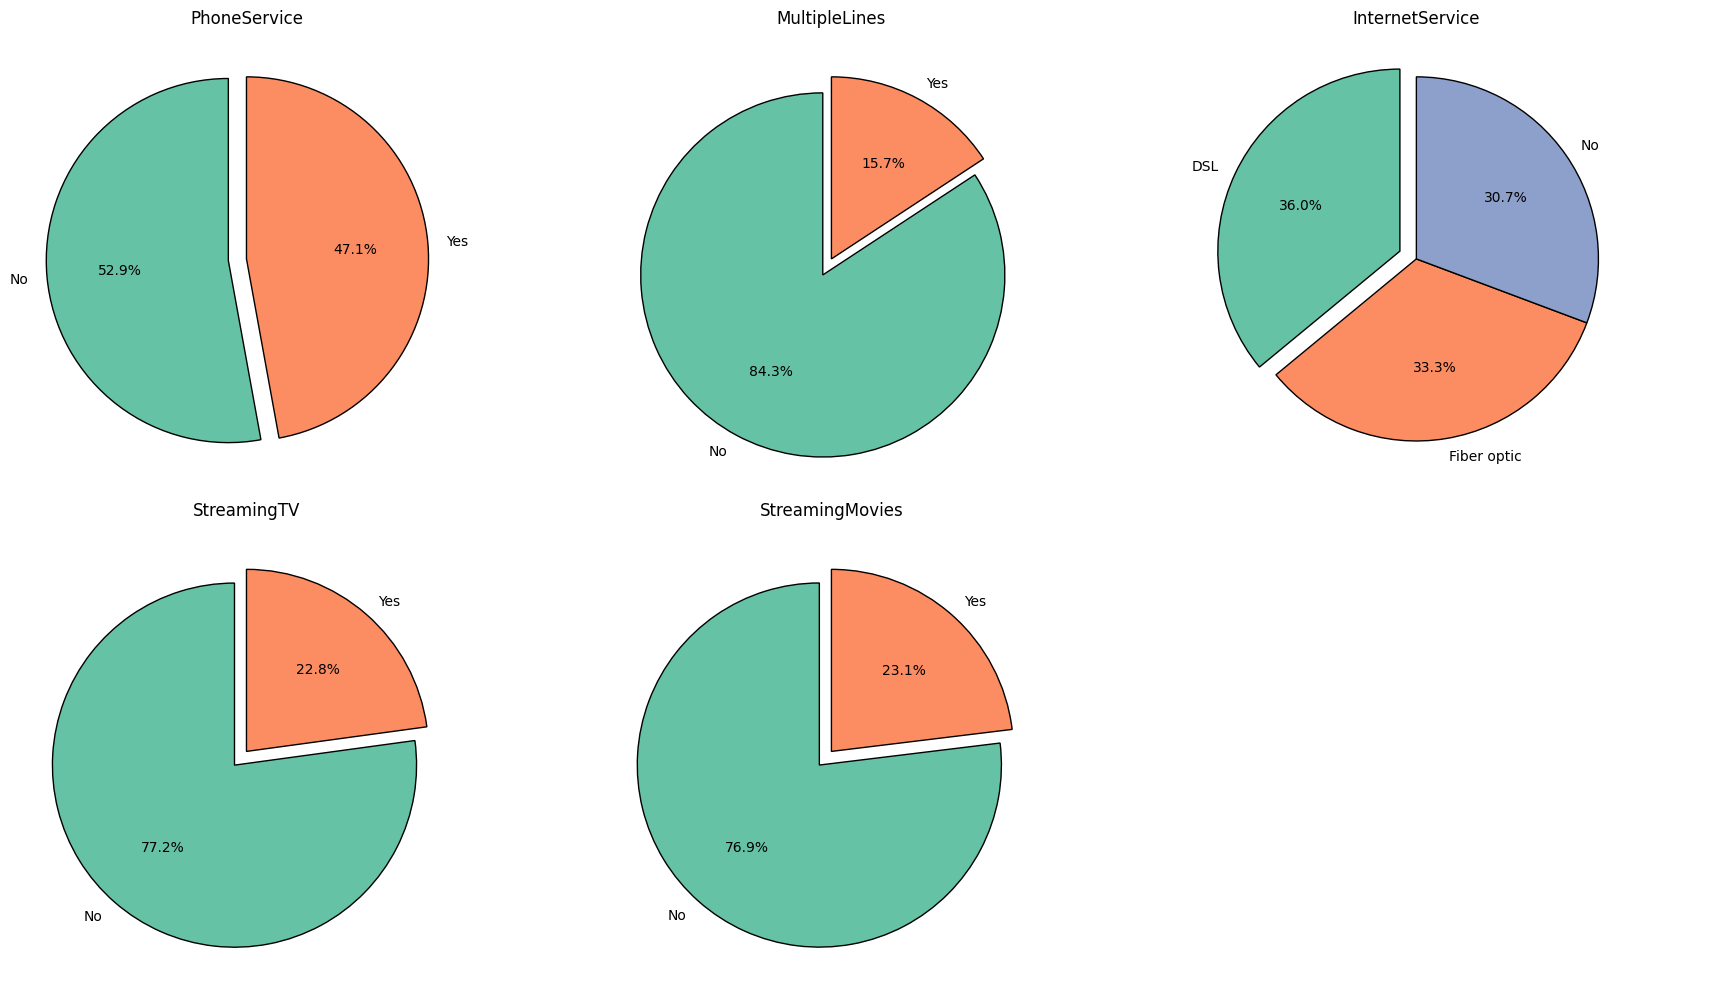

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
colors = sns.color_palette("Set2")

for i, col in enumerate(l2[0:5]):
    row, col_idx = divmod(i, 3)
    ax = axes[row, col_idx]
    
    # Get value counts and labels directly from data
    val_counts = df1[df1['Churn'] == 1][col].value_counts(normalize=True) * 100
    labels = val_counts.index.tolist()

    ax.pie(val_counts, labels=labels, autopct='%1.1f%%', startangle=90,
           explode=[0.1] + [0] * (len(labels) - 1),
           colors=colors[:len(labels)],
           wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    ax.set_title(col)

# Hide empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


**PhoneService:** Churn is slightly higher among customers without phone service.

**MultipleLines:** Churn is far more common among customers without multiple lines.

**InternetService:** DSL users have the highest churn share, slightly above Fiber and No-internet groups.

**StreamingTV:** Most churners do not have StreamingTV.

**StreamingMovies:** Most churners do not have StreamingMovies.

#### Group 2.2

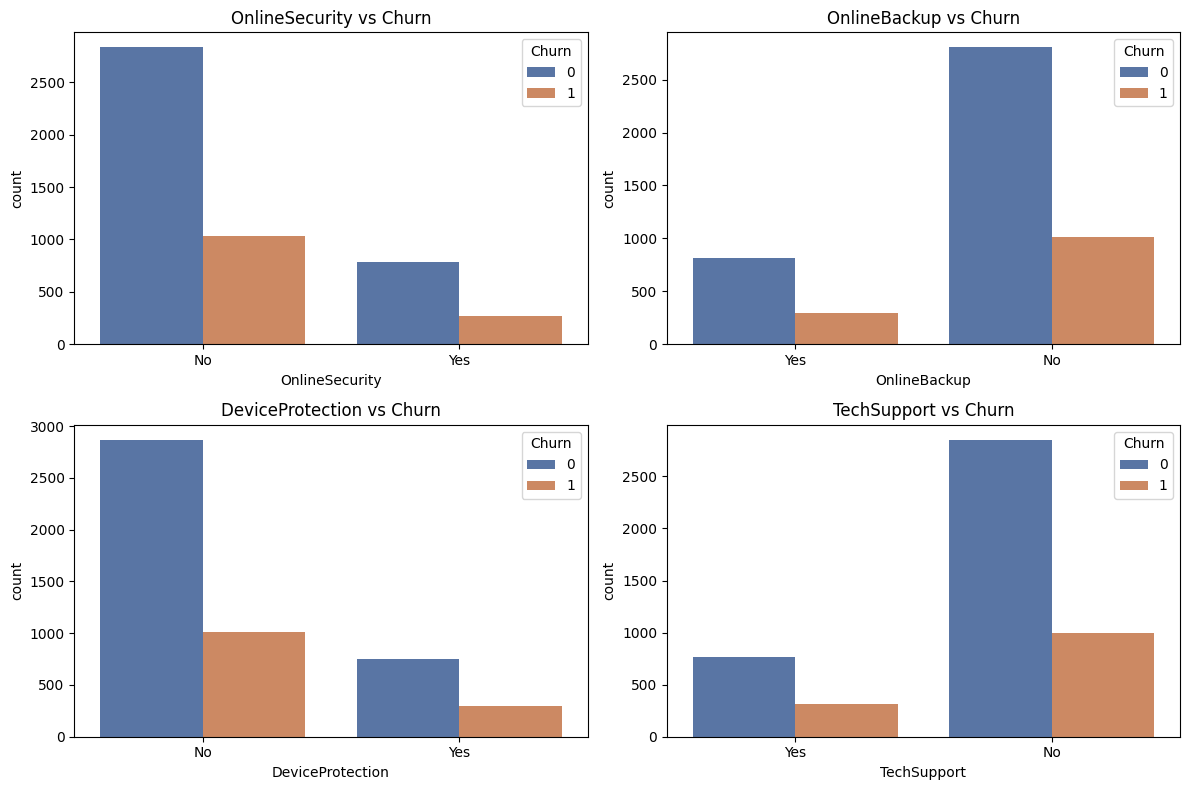

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i in range(4):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.countplot(x=l2[-4 + i], data=df1, hue="Churn", palette='deep', ax=ax)
    ax.set_title(f"{l2[-4 + i]} vs Churn")

plt.tight_layout()
plt.show()

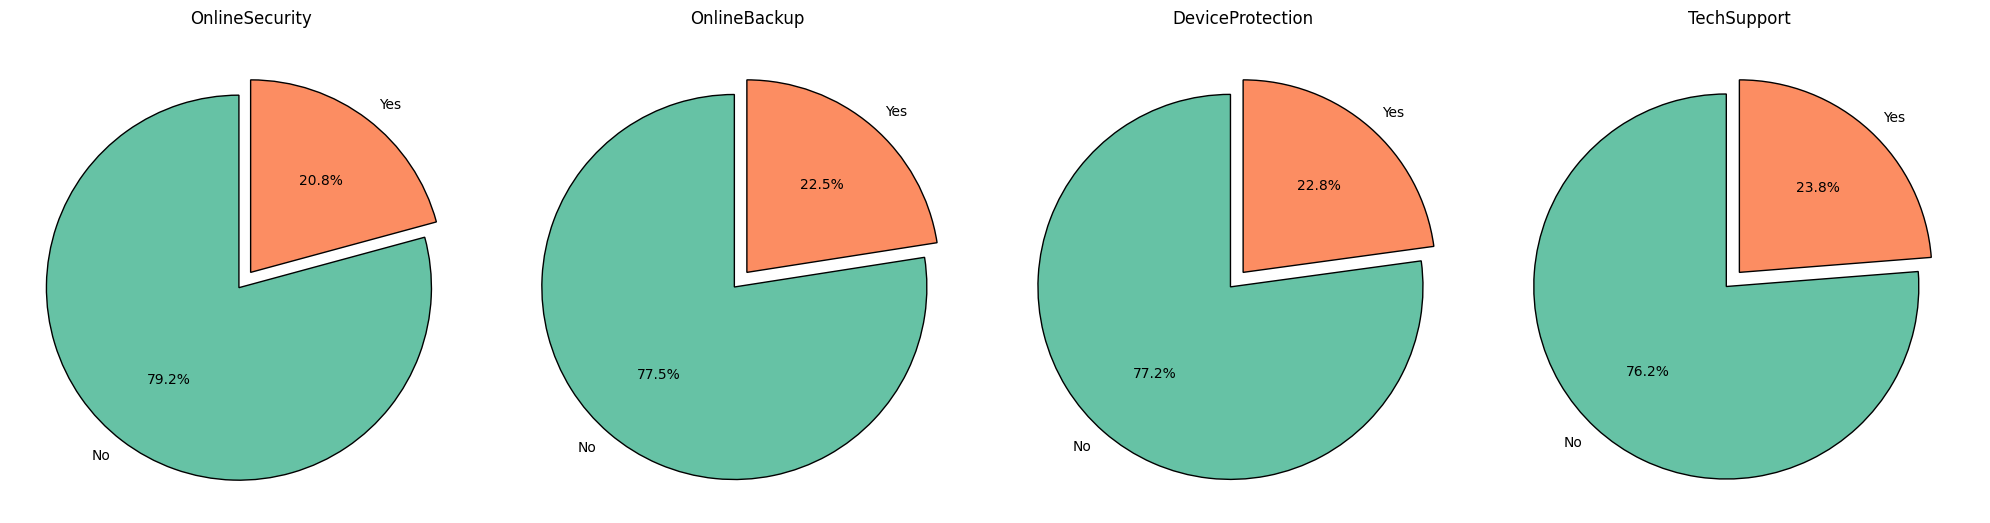

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
colors = sns.color_palette("Set2")

for i, col in enumerate(l2[-4:]):
    ax = axes[i]
    
    val_counts = df1[df1['Churn'] == 1][col].value_counts(normalize=True) * 100
    labels = val_counts.index.tolist()

    ax.pie(val_counts, labels=labels, autopct='%1.1f%%', startangle=90,
           explode=[0.1] + [0] * (len(labels) - 1),
           colors=colors[:len(labels)],
           wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    ax.set_title(col)

plt.tight_layout()
plt.show()


**OnlineSecurity**: Most churners do not have online security service.

**OnlineBackup:** Most churners do not have online backup service.

**DeviceProtection:** Most churners do not have device protection service.

**TechSupport:** Most churners do not have tech support service.

#### Group 3: Payment & Billing Information

This group encompasses features related to contractual terms, billing preferences, and payment methods

- Contract
- PaperlessBilling
- PaymentMethod

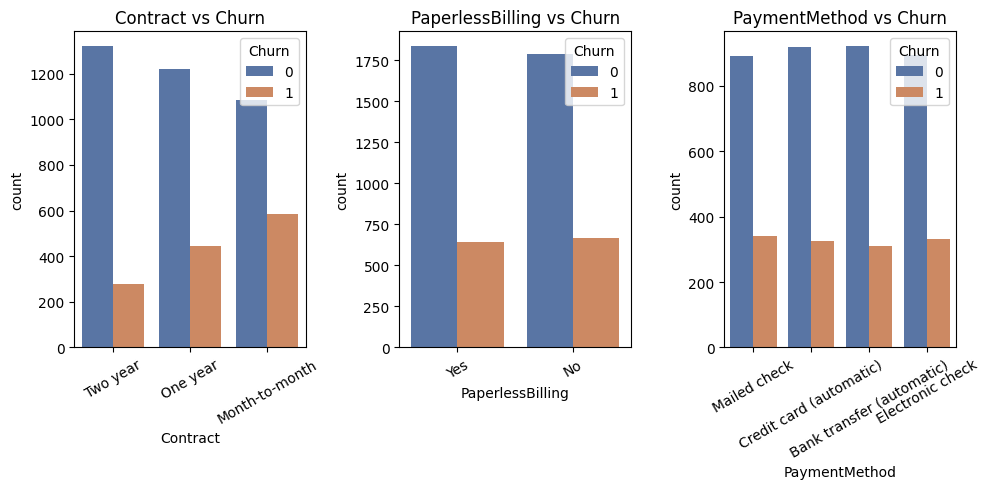

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i in range(3):
    ax = axes[i]
    sns.countplot(x=l3[i], data=df1, hue="Churn", palette='deep', ax=ax)
    ax.set_title(f"{l3[i]} vs Churn")
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

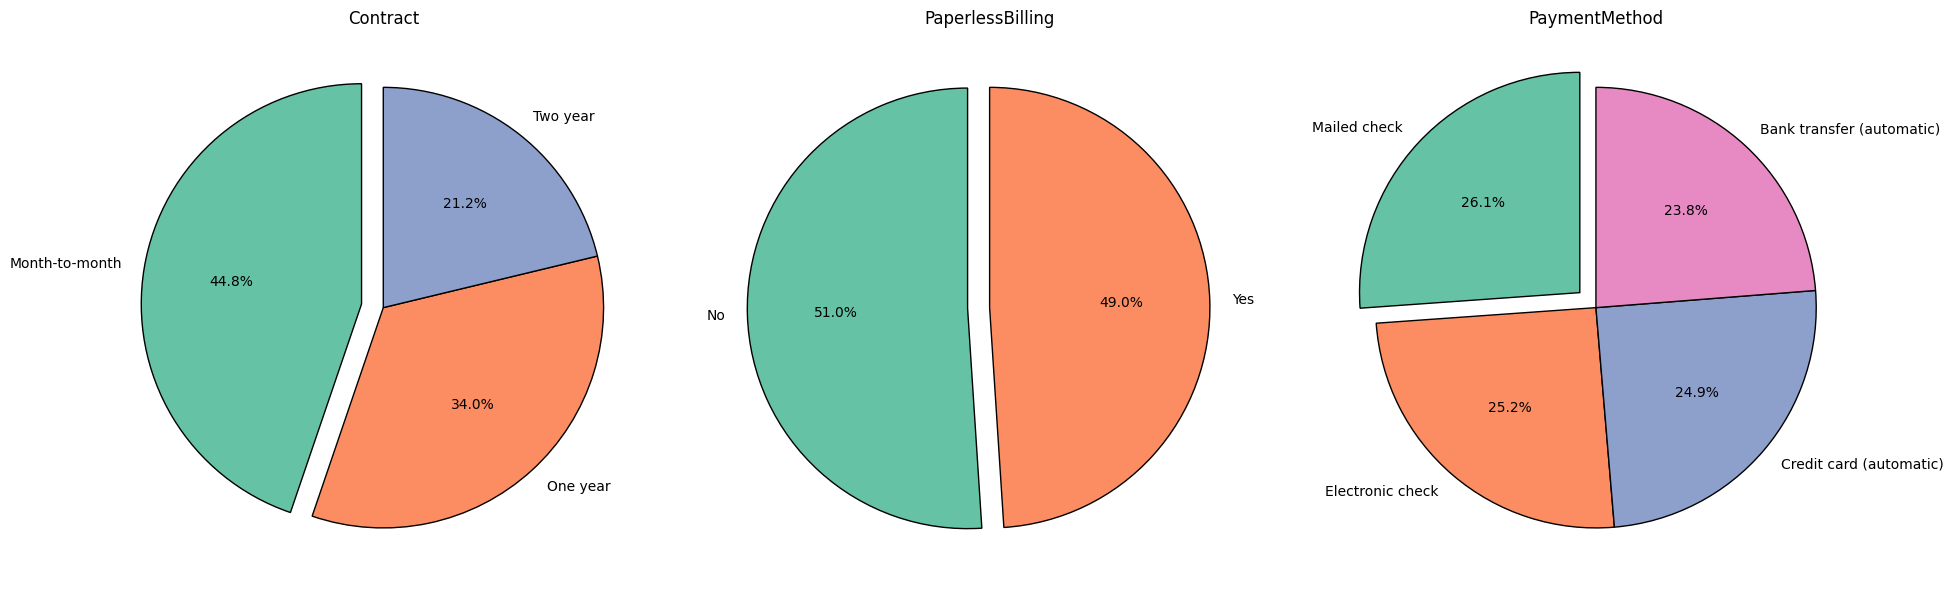

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
colors = sns.color_palette("Set2")

for i, col in enumerate(l3):
    ax = axes[i]
    
    val_counts = df1[df1['Churn'] == 1][col].value_counts(normalize=True) * 100
    labels = val_counts.index.tolist()

    ax.pie(val_counts, labels=labels, autopct='%1.1f%%', startangle=90,
           explode=[0.1] + [0] * (len(labels) - 1),
           colors=colors[:len(labels)],
           wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    ax.set_title(col)

plt.tight_layout()
plt.show()


- **Contract Duration Impact:** Churn is highest among Month-to-Month customers (44.8%), while Two-year contracts account for the least churn (21.2%), suggesting that longer commitments help reduce churn.

- **PaperlessBilling Analysis:** Churn is nearly balanced between users who opted in and out of PaperlessBilling, indicating no strong influence of billing mode on customer retention.

- **PaymentMethod Insights:** Churn is evenly distributed across all payment methods, with no method showing a dominant issue. This suggests payment method choice alone isn’t a major driver of churn in this dataset.

- **Overall Insight:** Contract length clearly plays a major role in churn behavior — longer-term contracts help retain customers. While billing type and payment method show less distinct patterns, understanding their interactions with other features may provide additional churn prevention strategies.

#### MonthlyCharges vs Contract Type with Churn

Text(0.5, 1.0, 'Monthly Charges by Contract Type and Churn Status')

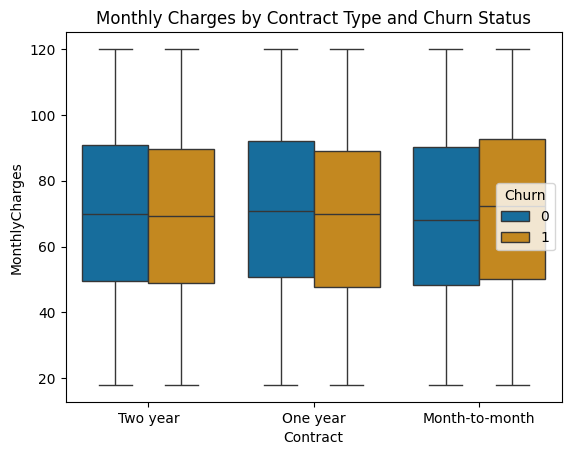

In [56]:
sns.boxplot(data=df1, x='Contract', y='MonthlyCharges', hue='Churn', palette="colorblind")
plt.title("Monthly Charges by Contract Type and Churn Status")

- Month-to-month contracts have higher monthly charges and higher churn rates than longer contracts.

#### Churn Rate by Dependent Status and Partrner

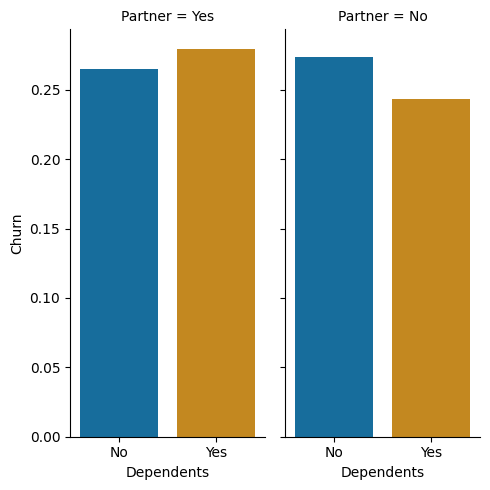

In [57]:
sns.catplot(data=df1, x='Dependents', y='Churn', col='Partner', kind='bar', ci=None, palette="colorblind", aspect=.5)

- When customer has both dependents and Partner then Churn rate is high and When customer has Dependents but no partner have low Churn rate.

#### Tenure in Months vs Churn

Text(0.5, 1.0, 'Tenure_(12-month_groups) vs Churn')

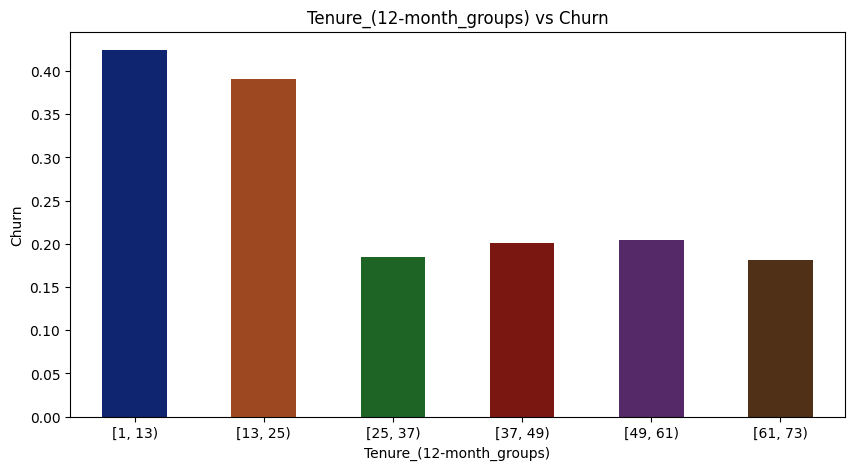

In [58]:
plt.figure(figsize=(10,5))
sns.barplot(data=df1,x="Tenure_(12-month_groups)",y="Churn", ci=None, palette='dark', width=0.5)
plt.title('Tenure_(12-month_groups) vs Churn')

**Tenure effect is strong:** Churn is highest in the first year (~42%) and still elevated in months 13–24 (~39%).

- After 24 months, churn drops sharply to roughly 18–21% and stays fairly steady.

- Longer stay, lower risk: the longer a customer has been with us, the less likely they are to leave.

Overall: Early-tenure customers are the flight risk; churn tapers off after the two-year mark.

### Categorical Features and Their Impact on the Target Variable (MonthlyCharges)

#### Monthly Charges by Service Group

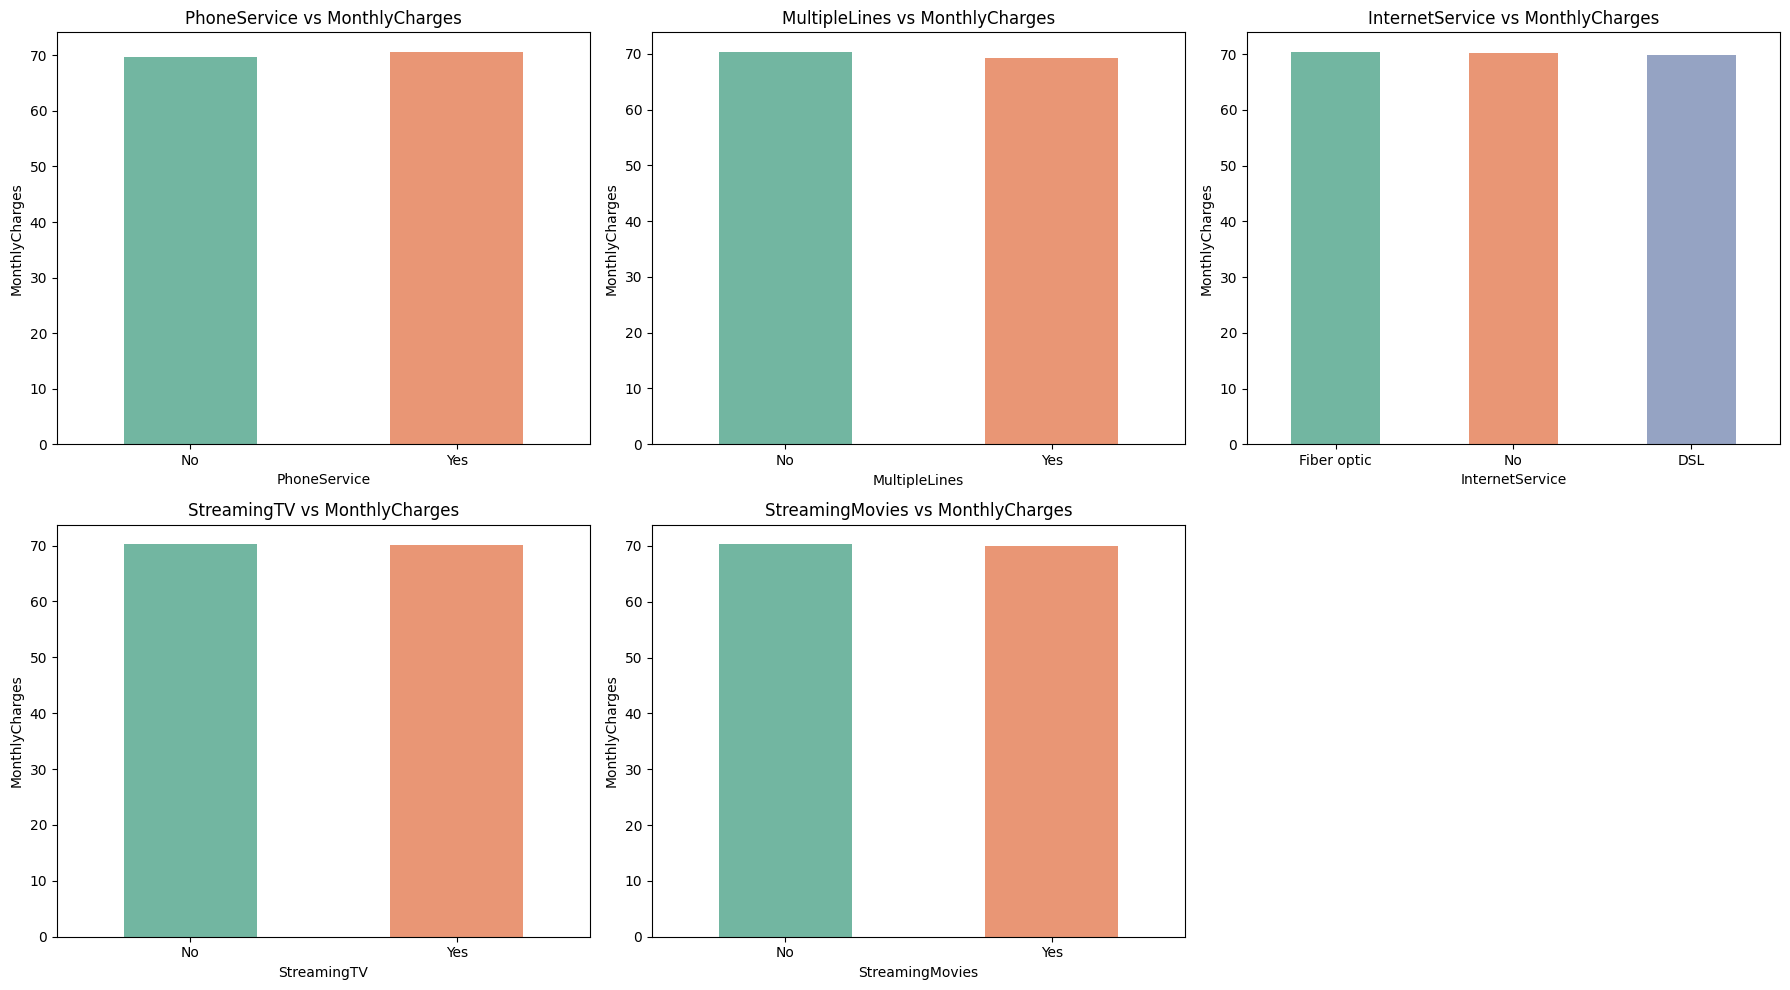

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i, col in enumerate(l2[0:5]):
    row, coln = divmod(i, 3)
    sns.barplot(x=col, y="MonthlyCharges", data=df1, palette="Set2", ax=axes[row, coln], ci=None, width=0.5)
    axes[row, coln].set_title(f"{col} vs MonthlyCharges")

axes[1, 2].axis('off')  # Hide the empty subplot
plt.tight_layout()
plt.show()

- All five services — PhoneService, MultipleLines, InternetService, StreamingTV, and StreamingMovies — show minimal impact on average MonthlyCharges, with values staying almost the same across categories.

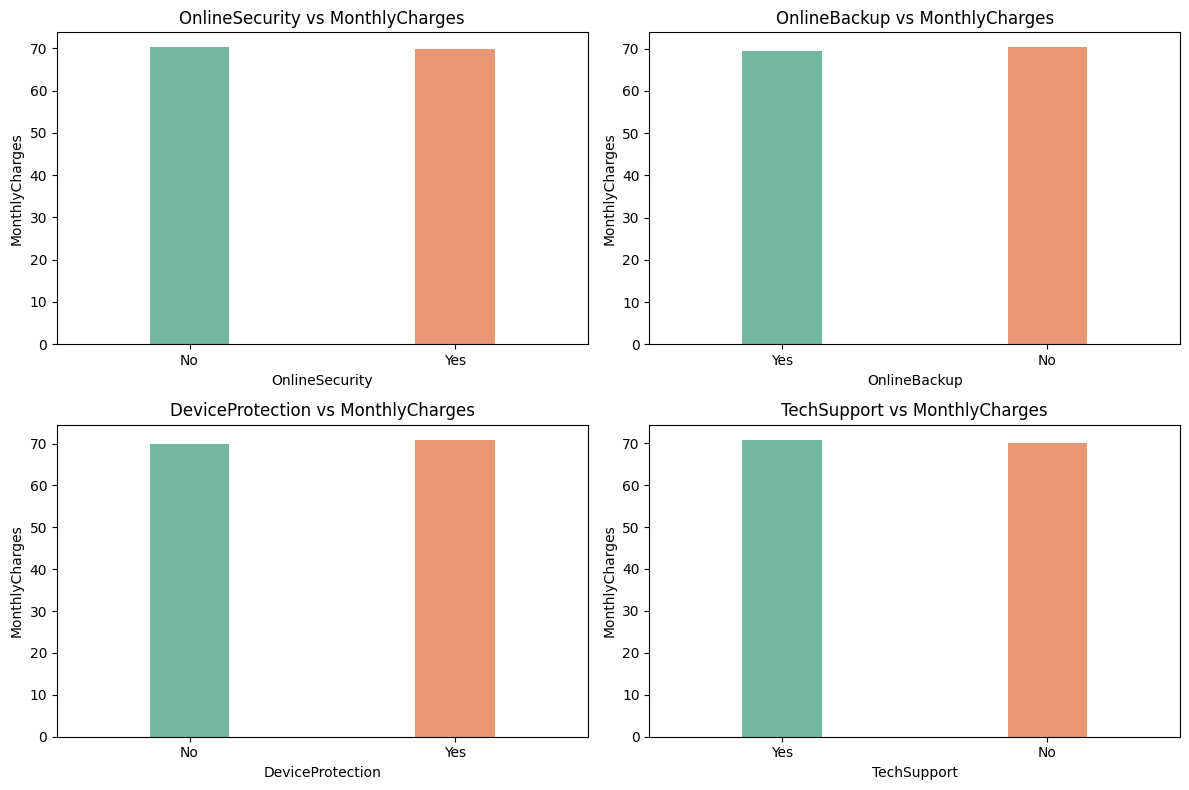

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, col in enumerate(l2[5:9]):
    row, coln = divmod(i, 2)
    sns.barplot(x=col, y="MonthlyCharges", data=df1, palette="Set2", ax=axes[row, coln], ci=None, width=0.3)
    axes[row, coln].set_title(f"{col} vs MonthlyCharges")

plt.tight_layout()
plt.show()

- OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport all show negligible impact on MonthlyCharges — average charges remain almost the same across all service categories.

In [61]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,TotalInternetServicesUsed,Tenure_(12-month_groups)
0,Male,0,Yes,No,No,No,Fiber optic,No,Yes,No,Yes,No,No,Two year,Yes,Mailed check,96.48,0,2,"[49, 61)"
1,Female,0,No,No,Yes,No,No,No,No,No,No,No,No,One year,No,Credit card (automatic),87.58,0,0,"[25, 37)"
2,Male,0,Yes,No,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),79.78,0,0,"[25, 37)"
3,Male,0,No,Yes,No,No,Fiber optic,No,Yes,No,No,No,No,One year,Yes,Bank transfer (automatic),112.28,1,1,"[13, 25)"
4,Male,1,No,Yes,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,45.77,1,1,"[25, 37)"


#### TotalInternetServicesUsed vs MonthlyCharges

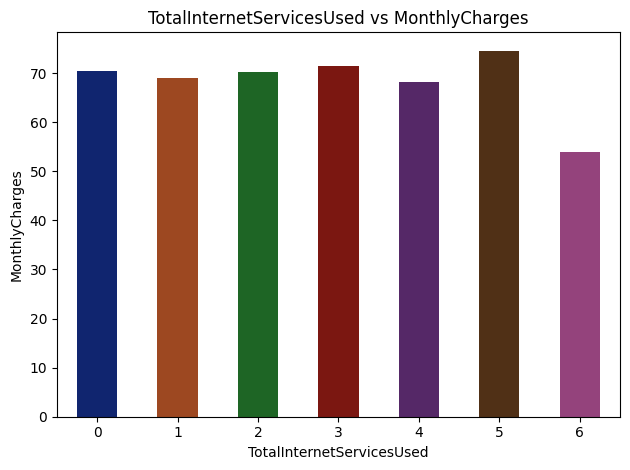

In [62]:
sns.barplot(x='TotalInternetServicesUsed', y="MonthlyCharges", data=df1, palette="dark", ci=None, width=0.5)
plt.title("TotalInternetServicesUsed vs MonthlyCharges")
plt.tight_layout()
plt.show()

- **TotalInternetServicesUsed**: Monthly charges are fairly consistent for 0–5 services, but drop noticeably for customers with all 6 services — likely due to bundled discounts. However, high charges for 0 services and other irregular patterns also point to possible data quality issues.

#### Contract, PaperlessBilling and PaymentMethod vs MonthlyCharges

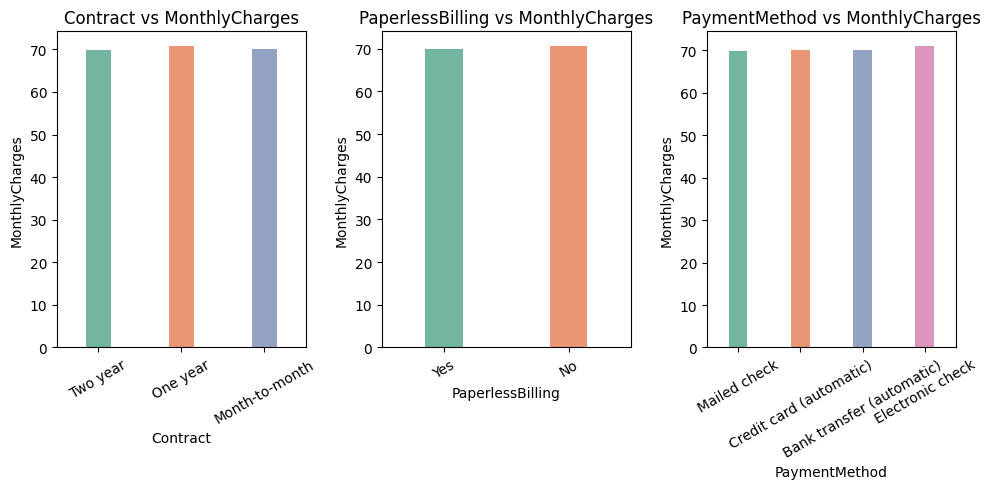

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, col in enumerate(l3[0:4]):
    sns.barplot(x=col, y="MonthlyCharges", data=df1, palette="Set2", ax=axes[i], ci=None, width=0.3)
    axes[i].set_title(f"{col} vs MonthlyCharges")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

- Contract – Monthly charges are nearly the same across contract types.

- PaperlessBilling – No difference in charges between Yes and No.

- PaymentMethod – Charges stay consistent across payment methods.

#### MonthlyCharges vs Dependents and Partner with Churn

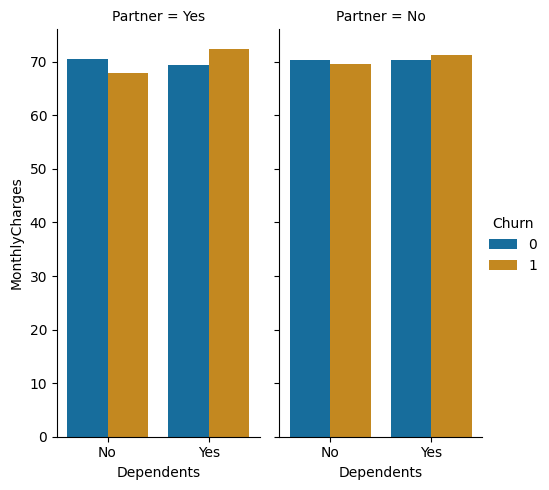

In [64]:
sns.catplot(data=df1, x='Dependents', y='MonthlyCharges', col='Partner', hue='Churn', kind='bar', ci=None, palette="colorblind", aspect=.5)

- Customers without dependents and a partner tend to have higher monthly charges and are more likely to churn.

#### Tenure in moths vs MonthlyCharges

Text(0.5, 1.0, 'Tenure_(12-month_groups) vs monthlycharges')

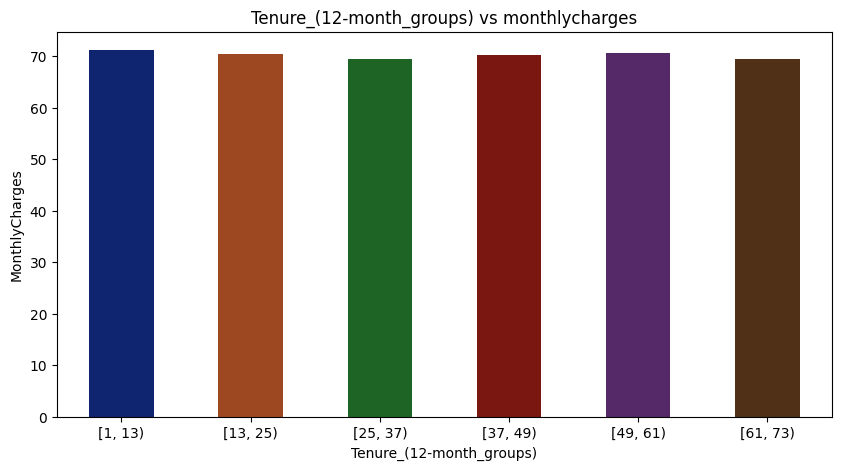

In [65]:
plt.figure(figsize=(10,5))
sns.barplot(data=df1,x="Tenure_(12-month_groups)",y="MonthlyCharges", ci=None, palette='dark', width=0.5)
plt.title('Tenure_(12-month_groups) vs monthlycharges')

- Monthly charges remain fairly consistent across all tenure groups, with no drastic upward or downward trend.
- Slight variations exist, but tenure length does not strongly influence the average monthly charges.

#### Seniorcitizen vs MonthlyCharges

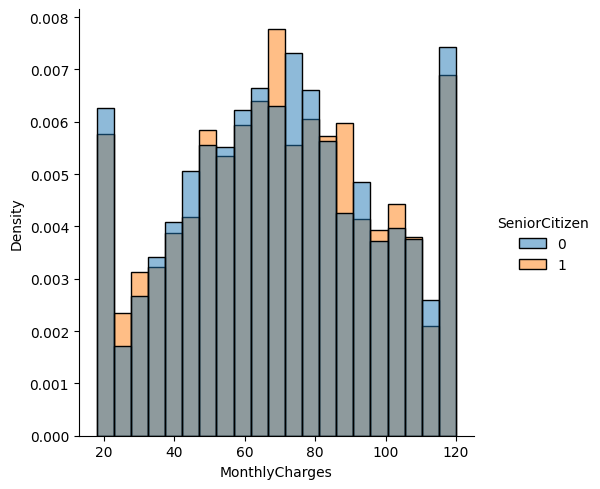

In [66]:
sns.displot(df1, x="MonthlyCharges", hue="SeniorCitizen", stat="density")

- Monthly charges are similarly distributed for both senior citizens and non-senior customers.
- No major difference in spending pattern between the two groups, indicating age isn’t a strong factor for charge variation.

In [67]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gender                     4931 non-null   object  
 1   SeniorCitizen              4931 non-null   object  
 2   Partner                    4931 non-null   object  
 3   Dependents                 4931 non-null   object  
 4   PhoneService               4931 non-null   object  
 5   MultipleLines              4931 non-null   object  
 6   InternetService            4931 non-null   object  
 7   OnlineSecurity             4931 non-null   object  
 8   OnlineBackup               4931 non-null   object  
 9   DeviceProtection           4931 non-null   object  
 10  TechSupport                4931 non-null   object  
 11  StreamingTV                4931 non-null   object  
 12  StreamingMovies            4931 non-null   object  
 13  Contract                   4931 non-nu

### Correlation & Heatmap (After Encoding)

In [68]:
df_encoded = pd.read_pickle("processed_data/data_mixed_encoded.pkl")
print("Encoded data loaded")

Encoded data loaded


In [69]:
df_encoded.head()

,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract,gender,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,MonthlyCharges,Churn,TotalInternetServicesUsed
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1,1,...,0,1,0,1,0,0,0,96.48,0,2
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,87.58,0,0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,...,0,0,0,0,0,0,0,79.78,0,0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,...,0,1,0,0,0,0,0,112.28,1,1
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,...,0,1,0,0,0,0,1,45.77,1,1


In [70]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931 entries, 0 to 4930
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   InternetService_DSL                      4931 non-null   float64
 1   InternetService_Fiber optic              4931 non-null   float64
 2   InternetService_No                       4931 non-null   float64
 3   PaymentMethod_Bank transfer (automatic)  4931 non-null   float64
 4   PaymentMethod_Credit card (automatic)    4931 non-null   float64
 5   PaymentMethod_Electronic check           4931 non-null   float64
 6   PaymentMethod_Mailed check               4931 non-null   float64
 7   Contract                                 4931 non-null   float64
 8   gender                                   4931 non-null   int64  
 9   Partner                                  4931 non-null   int64  
 10  Dependents                               4931 no

#### Heatmap Comparison of Churned vs Not Churned Customers (Mean Feature Distribution)


In [71]:
df_encoded[df_encoded['Churn'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
InternetService_DSL,1309.0,0.359817,0.480130,0.0,0.00,0.00,1.00,1.0
InternetService_Fiber optic,1309.0,0.333079,0.471495,0.0,0.00,0.00,1.00,1.0
InternetService_No,1309.0,0.307105,0.461469,0.0,0.00,0.00,1.00,1.0
PaymentMethod_Bank transfer (automatic),1309.0,0.237586,0.425767,0.0,0.00,0.00,0.00,1.0
PaymentMethod_Credit card (automatic),1309.0,0.249045,0.432625,0.0,0.00,0.00,0.00,1.0
PaymentMethod_Electronic check,1309.0,0.252101,0.434385,0.0,0.00,0.00,1.00,1.0
PaymentMethod_Mailed check,1309.0,0.261268,0.439494,0.0,0.00,0.00,1.00,1.0
Contract,1309.0,0.764706,0.777911,0.0,0.00,1.00,1.00,2.0
gender,1309.0,0.508785,0.500114,0.0,0.00,1.00,1.00,1.0
Partner,1309.0,0.513369,0.500012,0.0,0.00,1.00,1.00,1.0


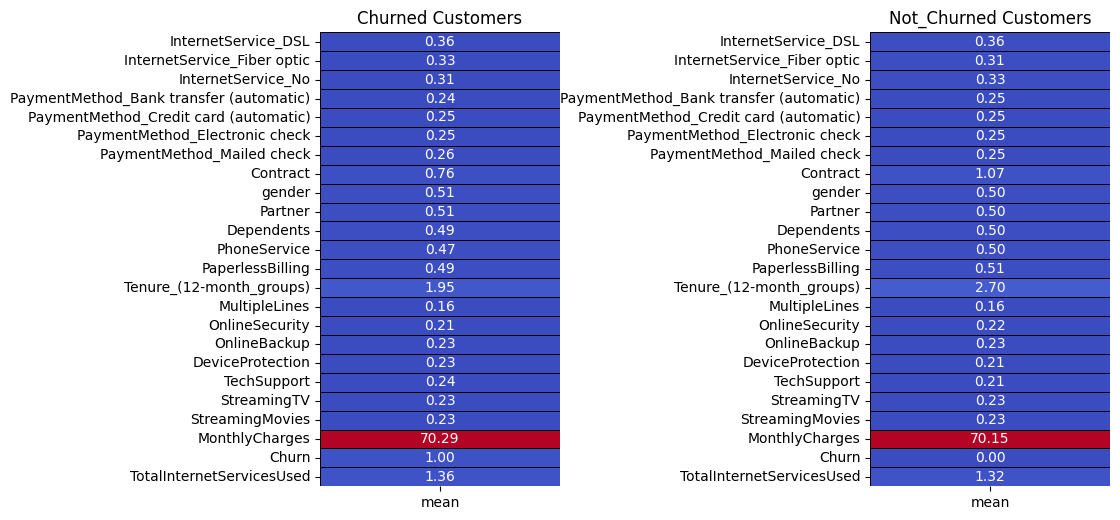

In [72]:
churn = df_encoded[df_encoded['Churn'] == 1].describe().T
not_churn = df_encoded[df_encoded['Churn'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (11,5))
plt.subplot(1,2,1)
sns.heatmap(churn[['mean']],annot = True,cmap = 'coolwarm',linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Churned Customers')

plt.subplot(1,2,2)
sns.heatmap(not_churn[['mean']],annot = True,cmap = 'coolwarm',linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Not_Churned Customers')

fig.tight_layout(pad = 0)

- Contract stands out: Churned customers skew toward month-to-month; stayers lean to 1–2 year contracts. Lock-in helps.

- Tenure matters: Churners are earlier-tenure on average; longer-tenure customers are steadier.

- Monthly Charges: About the same for both groups; price level alone isn’t deciding who leaves.

- Internet service type & payment method: Very similar mix across churned vs not—no clear winners/risks here.

- Add-ons (security/backup/tech support/streaming): No strong separation at this granularity.

- Total services used: Slightly higher among churners, but the gap is tiny.

Overall: Focus retention on early-lifecycle, month-to-month customers; the rest of these attributes show little standalone lift.

#### Correalation Heatmap of all features

In [73]:
df_encoded.head()

,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract,gender,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,MonthlyCharges,Churn,TotalInternetServicesUsed
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1,1,...,0,1,0,1,0,0,0,96.48,0,2
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,87.58,0,0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,1,...,0,0,0,0,0,0,0,79.78,0,0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,...,0,1,0,0,0,0,0,112.28,1,1
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,...,0,1,0,0,0,0,1,45.77,1,1


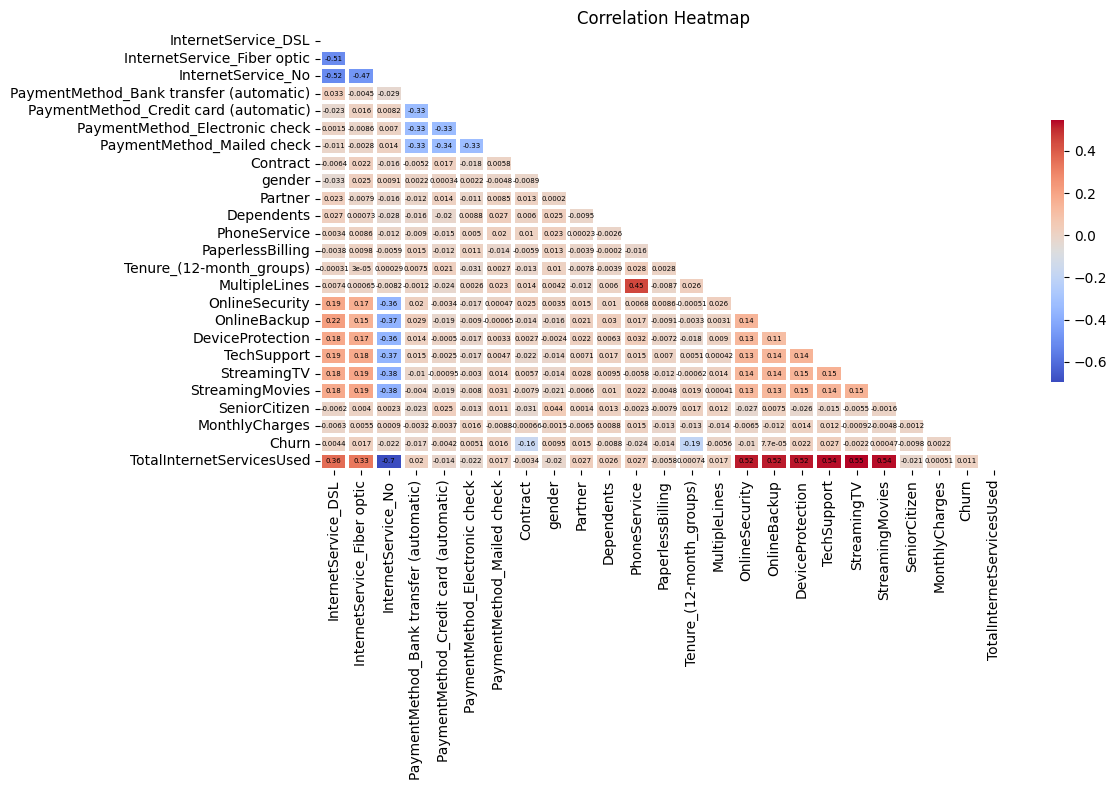

In [74]:
corr = df_encoded.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
plt.title("Correlation Heatmap")
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, linewidths=1.7, cbar_kws={"shrink": 0.6}, annot_kws={"size": 5, "color": 'black'})
plt.tight_layout()
plt.show()

#### Correlation plot of all features vs Churn

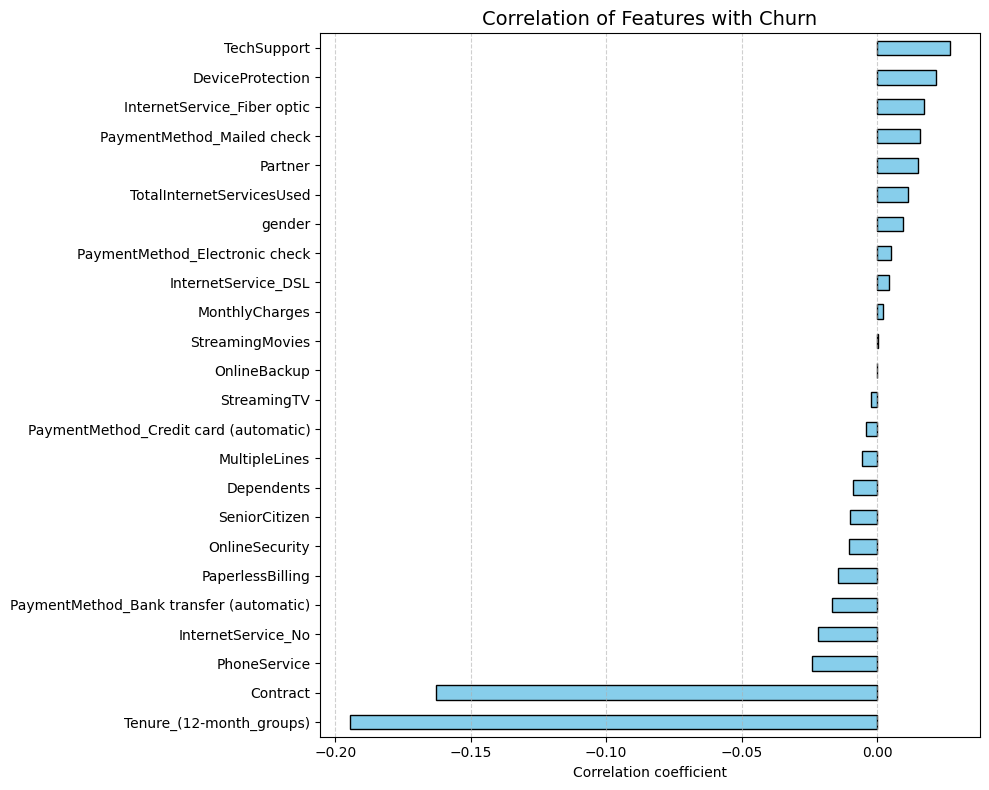

In [ ]:
# Compute correlation of all features with 'Churn'
churn_corr = df_encoded.corr()['Churn'].drop('Churn')  # exclude self-correlation

plt.figure(figsize=(10, 8))
churn_corr.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Correlation of Features with Churn", fontsize=14)
plt.xlabel("Correlation coefficient")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


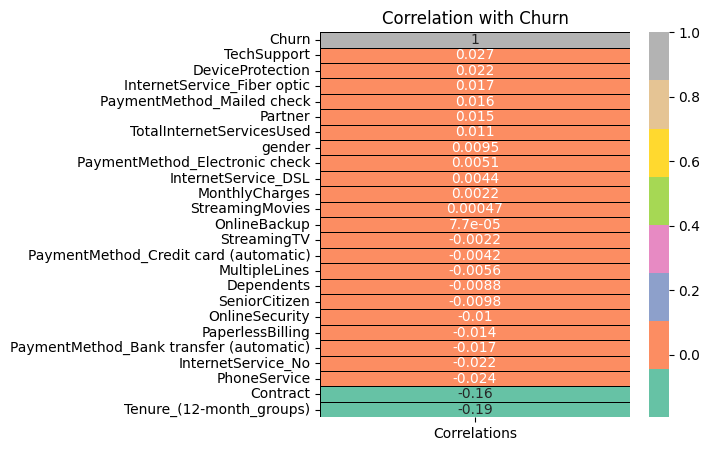

In [ ]:
# Calculate correlation matrix
corr = df_encoded.corr()['Churn'].sort_values(ascending=False).to_frame()
corr.columns = ['Correlations']

plt.subplots(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap=colors, linewidths=0.4, linecolor='black')
plt.title('Correlation with Churn')
plt.show()

#### Correlation plot of all features vs MonthlyCharges

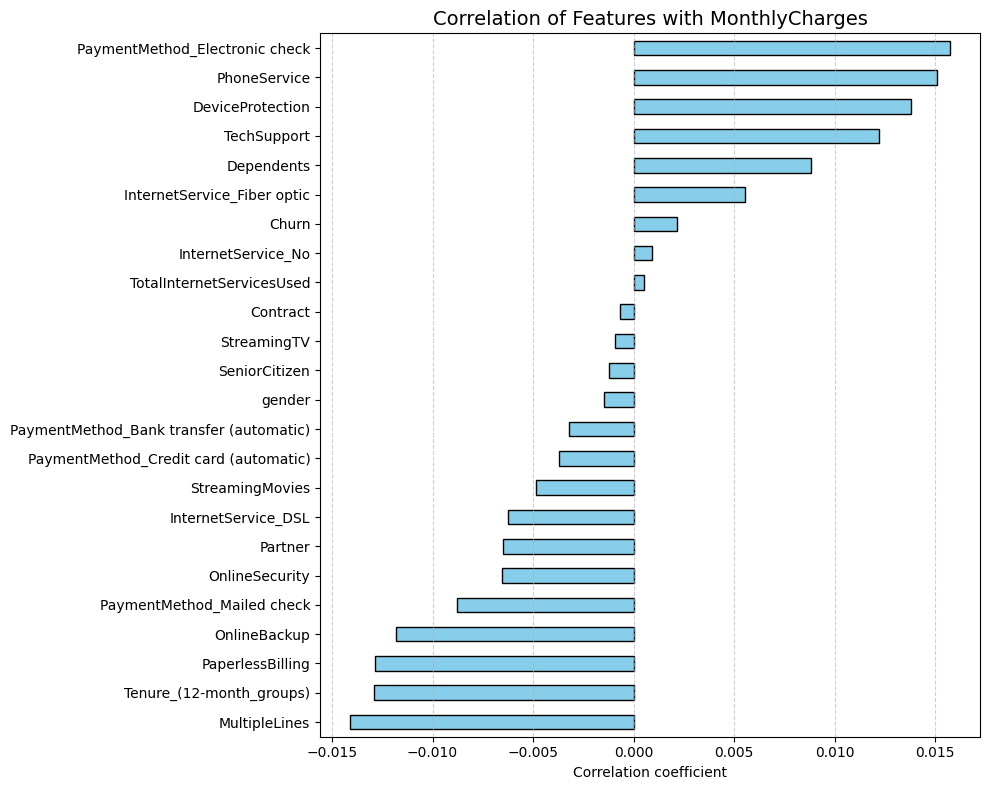

In [77]:
# Compute correlation of all features with 'MonthlyCharges'
monthlycharge_corr = df_encoded.corr()['MonthlyCharges'].drop('MonthlyCharges')  # exclude self-correlation

plt.figure(figsize=(10, 8))
monthlycharge_corr.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Correlation of Features with MonthlyCharges", fontsize=14)
plt.xlabel("Correlation coefficient")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


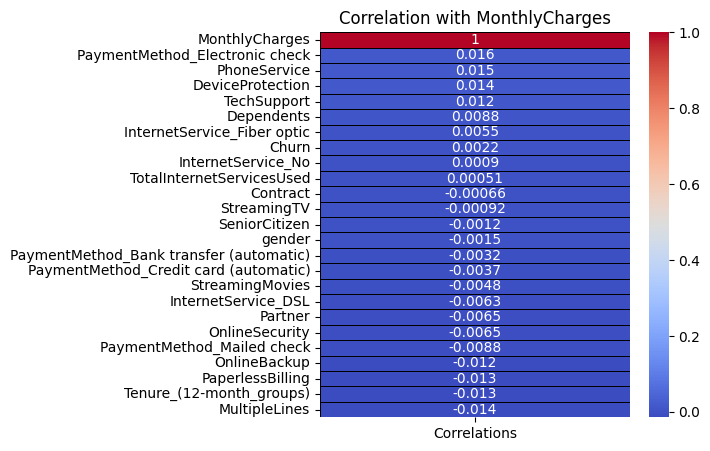

In [ ]:
# Calculate correlation matrix
corr = df_encoded.corr()['MonthlyCharges'].sort_values(ascending=False).to_frame()
corr.columns = ['Correlations']

plt.subplots(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black')
plt.title('Correlation with MonthlyCharges')
plt.show()

Skewness of MonthlyCharges: -0.02356967342760992


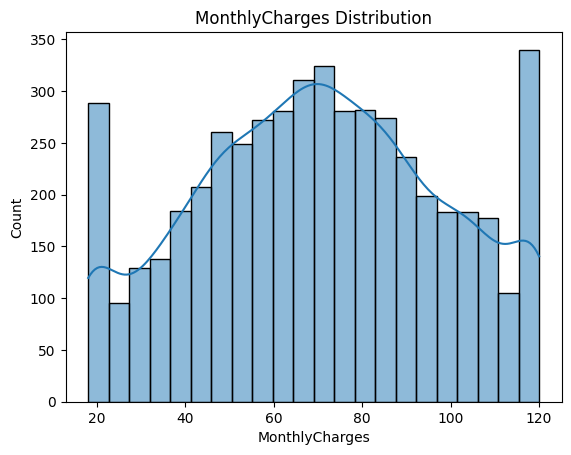

In [ ]:
# Skewness check
skew_val = df['MonthlyCharges'].skew()
print(f"Skewness of MonthlyCharges: {skew_val}")

sns.histplot(df['MonthlyCharges'], kde=True)
plt.title("MonthlyCharges Distribution")
plt.show()

##### Observations from MonthlyCharges Correlation Plot
- Customers with DeviceProtection, PhoneService, and StreamingTV tend to pay higher monthly charges.
- Users with Fiber optic internet pay more — confirms it's a premium service.
- Customers with no internet service have lower charges, as expected.
- MultipleLines has a slight negative correlation — possibly due to bundled discounts lowering average cost.

In [80]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931 entries, 0 to 4930
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   InternetService_DSL                      4931 non-null   float64
 1   InternetService_Fiber optic              4931 non-null   float64
 2   InternetService_No                       4931 non-null   float64
 3   PaymentMethod_Bank transfer (automatic)  4931 non-null   float64
 4   PaymentMethod_Credit card (automatic)    4931 non-null   float64
 5   PaymentMethod_Electronic check           4931 non-null   float64
 6   PaymentMethod_Mailed check               4931 non-null   float64
 7   Contract                                 4931 non-null   float64
 8   gender                                   4931 non-null   int64  
 9   Partner                                  4931 non-null   int64  
 10  Dependents                               4931 no

#### Identifying Imbalance data

In [81]:
df1['Churn'].value_counts(normalize=True) * 100

Churn
0    73.453661
1    26.546339
Name: proportion, dtype: float64

In [82]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gender                     4931 non-null   object  
 1   SeniorCitizen              4931 non-null   object  
 2   Partner                    4931 non-null   object  
 3   Dependents                 4931 non-null   object  
 4   PhoneService               4931 non-null   object  
 5   MultipleLines              4931 non-null   object  
 6   InternetService            4931 non-null   object  
 7   OnlineSecurity             4931 non-null   object  
 8   OnlineBackup               4931 non-null   object  
 9   DeviceProtection           4931 non-null   object  
 10  TechSupport                4931 non-null   object  
 11  StreamingTV                4931 non-null   object  
 12  StreamingMovies            4931 non-null   object  
 13  Contract                   4931 non-nu

**So, data is imbalanced**

## Saving Cleaned data for further steps

In [83]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gender                     4931 non-null   object  
 1   SeniorCitizen              4931 non-null   object  
 2   Partner                    4931 non-null   object  
 3   Dependents                 4931 non-null   object  
 4   PhoneService               4931 non-null   object  
 5   MultipleLines              4931 non-null   object  
 6   InternetService            4931 non-null   object  
 7   OnlineSecurity             4931 non-null   object  
 8   OnlineBackup               4931 non-null   object  
 9   DeviceProtection           4931 non-null   object  
 10  TechSupport                4931 non-null   object  
 11  StreamingTV                4931 non-null   object  
 12  StreamingMovies            4931 non-null   object  
 13  Contract                   4931 non-nu

In [84]:
# Save cleaned dataframe df1 to pickle
df1.to_pickle("processed_data/cleaned_data.pkl")
print("Cleaned data saved as cleaned_data.pkl")

Cleaned data saved as cleaned_data.pkl


In [88]:
df1[
    (df1['Churn'] == 0) &
    (df1['PhoneService'] == 'No') &
    (df1['InternetService'] == 'No') 
].describe()

,MonthlyCharges,Churn,TotalInternetServicesUsed
count,606.000000,606.0,606.0
mean,69.556617,0.0,0.0
std,27.012708,0.0,0.0
min,18.000000,0.0,0.0
25%,49.442500,0.0,0.0
50%,68.895000,0.0,0.0
75%,89.900000,0.0,0.0
max,120.000000,0.0,0.0


In [89]:
df1[
    (df1['Churn'] == 0) &
    (df1['PhoneService'] == 'Yes') &
    (df1['InternetService'] != 'No') 
].describe()

,MonthlyCharges,Churn,TotalInternetServicesUsed
count,1215.000000,1215.0,1215.000000
mean,70.863638,0.0,2.009053
std,28.056020,0.0,1.167553
min,18.000000,0.0,0.000000
25%,50.875000,0.0,1.000000
50%,70.860000,0.0,2.000000
75%,91.655000,0.0,3.000000
max,120.000000,0.0,6.000000


In [92]:
df1[
    (df1['TotalInternetServicesUsed'] == 0) &
    (df1['PhoneService'] != 'No') 
].describe()

,MonthlyCharges,Churn,TotalInternetServicesUsed
count,918.000000,918.000000,918.0
mean,71.040251,0.235294,0.0
std,28.653426,0.424414,0.0
min,18.000000,0.000000,0.0
25%,49.372500,0.000000,0.0
50%,71.535000,0.000000,0.0
75%,93.005000,0.000000,0.0
max,120.000000,1.000000,0.0
